# Preparations

In [1]:
import torch
import torchvision
import os.path

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn import manifold
from math import exp, sqrt
from torch.autograd import Variable
from my_dataset import MNIST_M
from my_dataset import ST_Dataset

%matplotlib inline
%load_ext skip_kernel_extension

In [2]:
import torch.utils.model_zoo as model_zoo

In [3]:
use_gpu = torch.cuda.is_available()
print("use_gpu = " + str(use_gpu))

use_gpu = True


# Structure

Pretrained AlexNet, with a 256-dimensional bottleneck on top of $\texttt{fc7}$.

In [4]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 256),
            nn.ReLU(inplace=True)
        )
        self.label_classifier = nn.Sequential(
            nn.Linear(256, 31)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        x = self.label_classifier(x)
        return x
    
    def load_pretrained_part(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                continue
            if isinstance(param, nn.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            own_state[name].copy_(param)

In [28]:
cnn_amazon = AlexNet()

model_url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"

cnn_amazon.load_pretrained_part(model_zoo.load_url(model_url))

for param in cnn_amazon.features.parameters():
    param.requires_grad = False

if (use_gpu):
    cnn_amazon.cuda()
print(cnn_amazon)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [29]:
def reset_seq(seq):
    for m in seq:
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, sqrt(2 / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            size = m.weight.size()
            fan_out = size[0] # number of rows
            fan_in = size[1] # number of columns
            m.weight.data.normal_(0, sqrt(2 / (fan_in + fan_out)))
            m.bias.data.zero_()
        elif hasattr(m, 'reset_parameters'):
            m.reset_parameters()

# Office Dataset

In [7]:
from data_loader import get_train_test_loader, get_office31_dataloader

In [8]:
trainloader_amazon, testloader_amazon = get_train_test_loader("amazon", batch_size=128, testing_size=0.1, img_size=(227, 227))

In [9]:
trainloader_webcam, testloader_webcam = get_train_test_loader("webcam", batch_size=128, testing_size=0.1, img_size=(227, 227))

len(amazon dataset)
2817

len(webcam dataset)
795

len(dslr dataset)
498

In [10]:
# this function takes the numpy input image with dim 3 x height x width
def convert_to_plt(input_image):
    input_image = input_image*np.asarray([0.229, 0.224, 0.225]) + np.asarray([0.485, 0.456, 0.406])
    return input_image

The 26th image in the first 128 images in the training set:


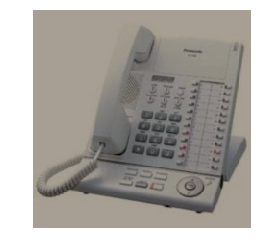

Its correspondent label:
tensor(20)


In [11]:
# randomly plot a sample from training set
import matplotlib.pyplot as plt

inputs = None
labels = None
for i, data in enumerate(trainloader_amazon):
    inputs, labels = data
    break

idx = np.random.randint(0, 128)
print("The " + str(idx) + "th image in the first 128" +\
      " images in the training set:")

plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(4,4))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

## Training on AMAZON

Or you can load the parameters directly.

In [30]:
import os.path
para_file_amazon = "./parameters/cnn_amazon.pt"
if not os.path.exists('./parameters'):
    os.makedirs('./parameters')
load_model_amazon = os.path.isfile(para_file_amazon)
print("load_model = " + str(load_model_amazon))

load_model = False


In [31]:
%%skip (not $load_model_amazon)
cnn_amazon.load_state_dict(torch.load(para_file_amazon))

### Optimizer

In [32]:
import torch.optim as optim

lr_init = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_amazon.parameters()), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

### Training process

In [33]:
%%skip $load_model_amazon

prev_loss = np.float("inf")
total_epoch = 40
finetune_epoch_start = 20
reset_seq(cnn_amazon.classifier)
reset_seq(cnn_amazon.label_classifier)

early_stop_cnt = 0

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    lr = adjust_lr(optimizer, p)
    if epoch == finetune_epoch_start:
        for param in cnn_amazon.features.parameters():
            param.requires_grad = True
            optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_amazon.parameters()), lr=lr, momentum=0.9)
    for i, data in enumerate(trainloader_amazon):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = cnn_amazon(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 2 == 1:    # print every 50 mini-batches
            print('[%2d] batch loss: %.3f' %
                  (i + 1, running_loss / 2))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        prev_loss = epoch_loss
        if epoch > finetune_epoch_start:
            early_stop_cnt += 1
            if early_stop_cnt > 2:
                break
    else:
        early_stop_cnt = 0
        prev_loss = epoch_loss

[ 2] batch loss: 6.700
[ 4] batch loss: 5.541
[ 6] batch loss: 4.459
[ 8] batch loss: 3.517
[10] batch loss: 3.258
[12] batch loss: 3.281
[14] batch loss: 3.232
[16] batch loss: 3.177
[18] batch loss: 2.975
[20] batch loss: 2.916
epoch 1 loss: inf -> 78.114

[ 2] batch loss: 2.820
[ 4] batch loss: 2.599
[ 6] batch loss: 2.583
[ 8] batch loss: 2.360
[10] batch loss: 2.506
[12] batch loss: 2.547
[14] batch loss: 2.294
[16] batch loss: 2.044
[18] batch loss: 2.242
[20] batch loss: 2.017
epoch 2 loss: 78.114 -> 48.022

[ 2] batch loss: 1.882
[ 4] batch loss: 1.919
[ 6] batch loss: 1.894
[ 8] batch loss: 1.773
[10] batch loss: 1.868
[12] batch loss: 1.737
[14] batch loss: 1.734
[16] batch loss: 1.592
[18] batch loss: 1.611
[20] batch loss: 1.691
epoch 3 loss: 48.022 -> 35.402

[ 2] batch loss: 1.338
[ 4] batch loss: 1.511
[ 6] batch loss: 1.452
[ 8] batch loss: 1.361
[10] batch loss: 1.590
[12] batch loss: 1.566
[14] batch loss: 1.429
[16] batch loss: 1.336
[18] batch loss: 1.379
[20] batch

[10] batch loss: 0.148
[12] batch loss: 0.106
[14] batch loss: 0.131
[16] batch loss: 0.128
[18] batch loss: 0.134
[20] batch loss: 0.146
epoch 32 loss: 2.851 -> 2.446

[ 2] batch loss: 0.136
[ 4] batch loss: 0.146
[ 6] batch loss: 0.129
[ 8] batch loss: 0.146
[10] batch loss: 0.155
[12] batch loss: 0.140
[14] batch loss: 0.120
[16] batch loss: 0.104
[18] batch loss: 0.112
[20] batch loss: 0.147
epoch 33 loss: 2.446 -> 2.668

[ 2] batch loss: 0.116
[ 4] batch loss: 0.090
[ 6] batch loss: 0.130
[ 8] batch loss: 0.110
[10] batch loss: 0.170
[12] batch loss: 0.083
[14] batch loss: 0.102
[16] batch loss: 0.063
[18] batch loss: 0.125
[20] batch loss: 0.120
epoch 34 loss: 2.668 -> 2.219

[ 2] batch loss: 0.139
[ 4] batch loss: 0.073
[ 6] batch loss: 0.132
[ 8] batch loss: 0.115
[10] batch loss: 0.151
[12] batch loss: 0.081
[14] batch loss: 0.085
[16] batch loss: 0.095
[18] batch loss: 0.112
[20] batch loss: 0.062
epoch 35 loss: 2.219 -> 2.092

[ 2] batch loss: 0.113
[ 4] batch loss: 0.104
[ 

In [16]:
%%skip $load_model_amazon

torch.save(cnn_amazon.state_dict(), para_file_amazon)

## Testing on AMAZON and WEBCAM

In [34]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        with torch.no_grad():
            #inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            inputs, labels = Variable(inputs), Variable(labels)
            outputs = model(inputs)
            correct += (torch.max(outputs.data, 1)[1] == labels.data).sum().item()
            total += labels.size()[0]
    acc = correct * 1.0 / total
    return acc

In [35]:
print("Accuracy on AMAZON test set (source only): " + str(evaluate_accuracy(cnn_amazon, testloader_amazon)))

Accuracy on AMAZON test set (source only): 0.7829181494661922


In [36]:
print("Accuracy on AMAZON test set (source only): " + str(evaluate_accuracy(cnn_amazon, testloader_webcam)))

Accuracy on AMAZON test set (source only): 0.5316455696202531


## Training on WEBCAM

In [20]:
cnn_webcam = AlexNet()

model_url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"

cnn_webcam.load_pretrained_part(model_zoo.load_url(model_url))

for param in cnn_webcam.features.parameters():
    param.requires_grad = False

if (use_gpu):
    cnn_webcam.cuda()
print(cnn_webcam)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The 52th image in the first 128 images in the training set:


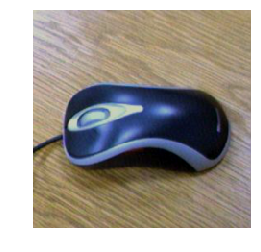

Its correspondent label:
tensor(16)


In [21]:
# randomly plot a sample from training set

inputs = None
labels = None
for i, data in enumerate(trainloader_webcam):
    inputs, labels = data
    break
    
idx = np.random.randint(0, 128)
print("The " + str(idx) + "th image in the first 128" +\
      " images in the training set:")

plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(4,4))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

In [22]:
para_file_webcam = "./parameters/cnn_webcam.pt"
load_model_webcam = os.path.isfile(para_file_webcam)
print("load_model_webcam = " + str(load_model_webcam))

load_model_webcam = True


In [24]:
%%skip (not $load_model_webcam)
cnn_webcam.load_state_dict(torch.load(para_file_webcam))

In [25]:
import torch.optim as optim

lr_init = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_webcam.parameters()), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [86]:
%%skip $load_model_webcam

prev_loss = np.float("inf")
total_epoch = 40
finetune_epoch_start = 20
reset_seq(cnn_webcam.classifier)
reset_seq(cnn_webcam.label_classifier)

early_stop_cnt = 0

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    lr = adjust_lr(optimizer, p)
    if epoch == finetune_epoch_start:
        for param in cnn_webcam.features.parameters():
            param.requires_grad = True
            optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_webcam.parameters()), lr=lr, momentum=0.9)
    for i, data in enumerate(trainloader_webcam):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = cnn_webcam(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 2 == 1:    # print every 50 mini-batches
            print('[%2d] batch loss: %.3f' %
                  (i + 1, running_loss / 2))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        prev_loss = epoch_loss
        if epoch > finetune_epoch_start:
            early_stop_cnt += 1
            if early_stop_cnt > 2:
                break
    else:
        early_stop_cnt = 0
        prev_loss = epoch_loss

[ 2] batch loss: 6.215
[ 4] batch loss: 5.002
[ 6] batch loss: 3.976
epoch 1 loss: inf -> 30.387

[ 2] batch loss: 3.322
[ 4] batch loss: 3.071
[ 6] batch loss: 3.028
epoch 2 loss: 30.387 -> 18.843

[ 2] batch loss: 2.948
[ 4] batch loss: 2.770
[ 6] batch loss: 2.518
epoch 3 loss: 18.843 -> 16.472

[ 2] batch loss: 2.286
[ 4] batch loss: 2.198
[ 6] batch loss: 1.940
epoch 4 loss: 16.472 -> 12.849

[ 2] batch loss: 1.863
[ 4] batch loss: 1.491
[ 6] batch loss: 1.353
epoch 5 loss: 12.849 -> 9.416

[ 2] batch loss: 1.030
[ 4] batch loss: 1.047
[ 6] batch loss: 1.017
epoch 6 loss: 9.416 -> 6.188

[ 2] batch loss: 0.640
[ 4] batch loss: 1.018
[ 6] batch loss: 0.738
epoch 7 loss: 6.188 -> 4.792

[ 2] batch loss: 0.624
[ 4] batch loss: 0.672
[ 6] batch loss: 0.485
epoch 8 loss: 4.792 -> 3.562

[ 2] batch loss: 0.546
[ 4] batch loss: 0.450
[ 6] batch loss: 0.448
epoch 9 loss: 3.562 -> 2.887

[ 2] batch loss: 0.385
[ 4] batch loss: 0.340
[ 6] batch loss: 0.293
epoch 10 loss: 2.887 -> 2.035

[ 2

In [90]:
%%skip $load_model_webcam

torch.save(cnn_webcam.state_dict(), para_file_webcam)

In [27]:
print("Accuracy on WEBCAM test set (train on target): " + str(evaluate_accuracy(cnn_webcam, testloader_webcam)))

Accuracy on WEBCAM test set (train on target): 1.0


# Unsupervised Domain Adaptation

## Structure (GRL)

In [99]:
len(list(enumerate(trainloader_amazon)))

20

In [101]:
dataiter = iter(trainloader_amazon)
images, labels = dataiter.next()

In [102]:
images.size()

torch.Size([128, 3, 227, 227])

The 48th image in the first 128 images in the training set:


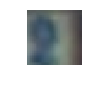

Its correspondent label:
2

From domain:
Source


In [25]:
# randomly plot a sample from test set

inputs = None
labels = None
for i, data in enumerate(trainloader_da):
    inputs, labels, domain = data
    if i == 2:
        break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")
plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:")
if labels[idx].item() == -1:
    print("I don't know :)\n")
else:
    print(str(labels[idx].item()) + "\n")

print("From domain:")
if domain[idx].item() == 0:
    print("Source")
else:
    print("Target")

In [26]:
class GRL_func(torch.autograd.Function):

    @staticmethod
    def forward(ctx, inputs, lamda):
        ctx.save_for_backward(lamda)
        return inputs

    @staticmethod
    def backward(ctx, grad_outputs):
        lamda, = ctx.saved_tensors
        return -lamda * grad_outputs, None

In [27]:
class GRL(nn.Module):
    
    def __init__(self, lamda_init):
        super(GRL, self).__init__()
        self.GRL_func = GRL_func.apply
        self.lamda = nn.Parameter(torch.Tensor(1), requires_grad=False)
        self.set_lamda(lamda_init)
        
    def forward(self, x):
        return self.GRL_func(x, self.lamda)
    
    def set_lamda(self, lamda_new):
        self.lamda[0] = lamda_new

![SVHN-MNIST Structure](https://c1.staticflickr.com/1/945/41945025492_f9db7ac20a_o.png)

In [28]:
class CNN_DA(nn.Module):
    
    def __init__(self, lamda_init=0):
        super(CNN_DA, self).__init__()
        # lamda
        self.lamda = lamda_init
        # feature extractor
        self.C1 = nn.Conv2d(3, 96, kernel_size=5, padding=2)
        self.C2 = nn.Conv2d(96, 144, kernel_size=5, padding=2)
        self.C3 = nn.Conv2d(144, 256, kernel_size=5, padding=2)
        # label classifier
        self.LC_FC1 = nn.Linear(256 * 4 * 4, 512)
        self.LC_FC2 = nn.Linear(512, 10)
        # domain classifier
        self.GRL_layer = GRL(lamda_init)
        self.DC_FC1 = nn.Linear(256 * 4 * 4, 1024)
        self.DC_FC2 = nn.Linear(1024, 1024)
        self.DC_FC3 = nn.Linear(1024, 1)
        
    def forward(self, x):
        # C1
        x = F.relu(self.C1(x))
        # M1
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # C2
        x = F.relu(self.C2(x))
        # M2
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # C3
        x = F.relu(self.C3(x))
        # M3
        x = F.max_pool2d(x, (2, 2), stride=(2, 2))
        # x's size is (128, 256, 4, 4)
        # flatten
        x = x.view(-1, 256 * 4 * 4)
        f = x
        # label classifier
        # LC_FC1
        x_l = F.relu(self.LC_FC1(x))
        lh = x_l
        # LC_FC2
        x_l = self.LC_FC2(x_l)
        # domain classifier
        # GRL
        x_d = self.GRL_layer(x)
        # DC_FC1
        x_d = F.relu(self.DC_FC1(x_d))
        # DC_FC2
        x_d = F.relu(self.DC_FC2(x_d))
        # DC_FC3
        x_d = F.sigmoid(self.DC_FC3(x_d))
        return x_l, x_d, f, lh
    
    def set_lamda(self, lamda_new):
        self.GRL_layer.set_lamda(lamda_new)

In [29]:
def extract_features_da(model, dataloader):
    features = None
    lasthidden = None
    labels = None
    for i, data in enumerate(dataloader):
        inputs, labels_ = data
        if (use_gpu):
            inputs = inputs.cuda()
        with torch.no_grad():
            inputs = Variable(inputs, requires_grad=False)
            _, _, f, l = model(inputs)
            if i == 0:
                features = f
                lasthidden = l
                labels = labels_
            else:
                features = torch.cat((features, f))
                lasthidden = torch.cat((lasthidden, l))
                labels = torch.cat((labels, labels_))
    features = features.data
    lasthidden = lasthidden.data
    if use_gpu:
        features = features.cpu()
        lasthidden = lasthidden.cpu()
    return features, lasthidden, labels

In [44]:
cnn_da = CNN_DA(0)
if (use_gpu):
    cnn_da.cuda()
print(cnn_da)

CNN_DA(
  (C1): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (C2): Conv2d(96, 144, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (C3): Conv2d(144, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LC_FC1): Linear(in_features=4096, out_features=512, bias=True)
  (LC_FC2): Linear(in_features=512, out_features=10, bias=True)
  (GRL_layer): GRL()
  (DC_FC1): Linear(in_features=4096, out_features=1024, bias=True)
  (DC_FC2): Linear(in_features=1024, out_features=1024, bias=True)
  (DC_FC3): Linear(in_features=1024, out_features=1, bias=True)
)


In [31]:
para_file_da = "./parameters/cnn_svhn_to_mnist.pt"
load_model_da = os.path.isfile(para_file_da)
print("load_model_da = " + str(load_model_da))

load_model_da = True


In [32]:
%%skip (not $load_model_da)
cnn_da.load_state_dict(torch.load(para_file_da))

### Optimizer

In [50]:
from math import exp

lr_init = 0.01
criterion_LC = nn.CrossEntropyLoss()
criterion_DC = nn.BCELoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_da.parameters()), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr
        
def adjust_lamda(model, p):
    gamma = 10
    lamda = 2 / (1 + exp(- gamma * p)) - 1
    model.set_lamda(lamda)
    return lamda

### Training process

In [51]:
#%%skip $load_model_da

prev_loss = np.float("inf")
prev_loss_LC = np.float("inf")
prev_loss_DC = np.float("inf")
total_epoch = 30
reset(cnn_da)

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    epoch_loss_LC = 0.0
    epoch_loss_DC = 0.0
    p = epoch * 1.0 / total_epoch
    # adjust_lr(optimizer, p)
    lamda = adjust_lamda(cnn_da, p)
    for i, data in enumerate(trainloader_da):
        # get inputs
        source_size = data[0].size()[0] // 2
        inputs, labels, domains = data
        domains = domains.to(torch.float32)
        if (use_gpu):
            inputs, labels, domains = inputs.cuda(), labels.cuda(), domains.cuda()
        inputs, labels, domains = Variable(inputs), Variable(labels), Variable(domains)
        optimizer.zero_grad()
        # forward
        outputs_LC, outputs_DC, f, l = cnn_da(inputs)
        # compute loss
        outputs_DC = outputs_DC.view(-1)
        loss_LC = criterion_LC(outputs_LC[:source_size], labels[:source_size])
        loss_DC = criterion_DC(outputs_DC, domains)
        loss = loss_LC + loss_DC
        # backward
        loss.backward()
        optimizer.step()
        # stat
        epoch_loss += loss.item()
        running_loss += loss.item()
        epoch_loss_LC += loss_LC.item()
        epoch_loss_DC += loss_DC.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%3d] batch loss: %.3f' %
                  (i + 1, running_loss / 50))
            running_loss = 0.0
#     f_da, lh_da, _ = extract_features_da(cnn_da, testloader)
#     f_m_da, lh_m_da, _ = extract_features_da(cnn_da, testloader_m)
#     visualize_da(f_da.numpy(), f_m_da.numpy(), perplexity=30, sample_num=200,
#                  save="./pics/f_" + str(epoch + 1) + ".svg")
#     visualize_da(lh_da.numpy(), lh_m_da.numpy(), perplexity=30, sample_num=200,
#                  save="./pics/lh_" + str(epoch + 1) + ".svg")
    print("epoch %d loss: %.3f -> %.3f" % (epoch + 1, prev_loss, epoch_loss))
    print("LC loss: %.3f -> %.3f" % (prev_loss_LC, epoch_loss_LC))
    print("DC loss: %.3f -> %.3f" % (prev_loss_DC, epoch_loss_DC))
    print(("Label classifier accuracy on MNIST test set (DA): %f\n"
           "Domain classifier accuracy on MNIST test set (DA): %f\n")
          %evaluate_da_accuracy(cnn_da, testloader, source=False))
    if prev_loss - epoch_loss < 0.1:
        prev_loss = epoch_loss
        prev_loss_LC = epoch_loss_LC
        prev_loss_DC = epoch_loss_DC
        pass
    else:
        prev_loss = epoch_loss
        prev_loss_LC = epoch_loss_LC
        prev_loss_DC = epoch_loss_DC

[ 50] batch loss: 2.667
[100] batch loss: 2.236
[150] batch loss: 1.857
[200] batch loss: 1.161
[250] batch loss: 0.869
[300] batch loss: 0.732
[350] batch loss: 0.711
[400] batch loss: 0.611
[450] batch loss: 0.587
[500] batch loss: 0.565
[550] batch loss: 0.534
[600] batch loss: 0.504
[650] batch loss: 0.487
[700] batch loss: 0.486
[750] batch loss: 0.447
[800] batch loss: 0.450
[850] batch loss: 0.475
[900] batch loss: 0.437
epoch 1 loss: inf -> 806.050
LC loss: inf -> 768.382
DC loss: inf -> 37.668
Label classifier accuracy on MNIST test set (DA): 0.509900
Domain classifier accuracy on MNIST test set (DA): 0.997260

[ 50] batch loss: 0.397
[100] batch loss: 0.424
[150] batch loss: 0.403
[200] batch loss: 0.369
[250] batch loss: 0.361
[300] batch loss: 0.379
[350] batch loss: 0.423
[400] batch loss: 0.370
[450] batch loss: 0.337
[500] batch loss: 0.335
[550] batch loss: 0.323
[600] batch loss: 0.308
[650] batch loss: 0.317
[700] batch loss: 0.301
[750] batch loss: 0.277
[800] batch 

[ 50] batch loss: 0.024
[100] batch loss: 0.019
[150] batch loss: 0.033
[200] batch loss: 0.022
[250] batch loss: 0.023
[300] batch loss: 0.014
[350] batch loss: 0.034
[400] batch loss: 0.020
[450] batch loss: 0.030
[500] batch loss: 0.022
[550] batch loss: 0.026
[600] batch loss: 0.019
[650] batch loss: 0.027
[700] batch loss: 0.023
[750] batch loss: 0.019
[800] batch loss: 0.020
[850] batch loss: 0.019
[900] batch loss: 0.014
epoch 14 loss: 20.854 -> 21.259
LC loss: 20.304 -> 19.929
DC loss: 0.550 -> 1.329
Label classifier accuracy on MNIST test set (DA): 0.634700
Domain classifier accuracy on MNIST test set (DA): 0.998066

[ 50] batch loss: 0.012
[100] batch loss: 0.025
[150] batch loss: 0.015
[200] batch loss: 0.016
[250] batch loss: 0.015
[300] batch loss: 0.020
[350] batch loss: 0.029
[400] batch loss: 0.018
[450] batch loss: 0.020
[500] batch loss: 0.016
[550] batch loss: 0.018
[600] batch loss: 0.026
[650] batch loss: 0.017
[700] batch loss: 0.019
[750] batch loss: 0.014
[800] 

[ 50] batch loss: 0.003
[100] batch loss: 0.005
[150] batch loss: 0.010
[200] batch loss: 0.008
[250] batch loss: 0.004
[300] batch loss: 0.006
[350] batch loss: 0.017
[400] batch loss: 0.012
[450] batch loss: 0.016
[500] batch loss: 0.013
[550] batch loss: 0.007
[600] batch loss: 0.003
[650] batch loss: 0.005
[700] batch loss: 0.003
[750] batch loss: 0.009
[800] batch loss: 0.007
[850] batch loss: 0.010
[900] batch loss: 0.003
epoch 27 loss: 6.218 -> 7.147
LC loss: 6.146 -> 6.944
DC loss: 0.072 -> 0.203
Label classifier accuracy on MNIST test set (DA): 0.640000
Domain classifier accuracy on MNIST test set (DA): 0.999583

[ 50] batch loss: 0.002
[100] batch loss: 0.003
[150] batch loss: 0.006
[200] batch loss: 0.003
[250] batch loss: 0.014
[300] batch loss: 0.023
[350] batch loss: 0.014
[400] batch loss: 0.016
[450] batch loss: 0.007
[500] batch loss: 0.010
[550] batch loss: 0.006
[600] batch loss: 0.017
[650] batch loss: 0.013
[700] batch loss: 0.007
[750] batch loss: 0.018
[800] batc

In [94]:
%%skip $load_model_da

torch.save(cnn_da.state_dict(), para_file_da)

### Test on SVHN and MNIST dataset

In [34]:
def evaluate_da_accuracy(model, dataloader, source):
    model.eval()
    correct_LC = 0
    correct_DC = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            if (use_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)
            outputs_LC, outputs_DC, _, _ = model(inputs)
            correct_LC += (torch.max(outputs_LC.data, 1)[1] == labels.data).sum().item()
            if source:
                correct_DC += labels.size()[0] - outputs_DC.data.sum().item()
            else:
                correct_DC += outputs_DC.data.sum().item()
            total += labels.size()[0]
        acc_LC = correct_LC / total
        acc_DC = correct_DC / total
    return acc_LC, acc_DC

In [35]:
print(("Label classifier accuracy on SVHN test set (DA): %f\n"
       "Domain classifier accuracy on SVHN test set (DA): %f")
      %evaluate_da_accuracy(cnn_da, testloader_svhn, source=True))

Label classifier accuracy on SVHN test set (DA): 0.919215
Domain classifier accuracy on SVHN test set (DA): 0.999045


In [36]:
print(("Label classifier accuracy on MNIST test set (DA): %f\n"
       "Domain classifier accuracy on MNIST test set (DA): %f")
      %evaluate_da_accuracy(cnn_da, testloader, source=False))

Label classifier accuracy on MNIST test set (DA): 0.697800
Domain classifier accuracy on MNIST test set (DA): 1.000000


### Visualization

In [95]:
f_svhn_da, lh_svhn_da, l_svhn_da = extract_features_da(cnn_da, testloader_svhn)
f_da, lh_da, l_da = extract_features_da(cnn_da, testloader)

Features of MNIST test set (extracted by DA model)

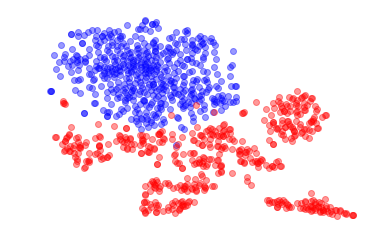

In [96]:
visualize_da(f_svhn_da.numpy(), f_da.numpy(), perplexity=50, sample_num=500,
             save="./pics/SVHN_to_MNIST_features_Adapted.svg")

Features of MNIST-M test set (extracted by DA model)

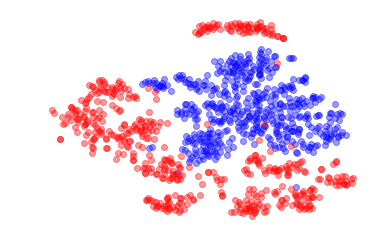

In [97]:
visualize_da(lh_svhn_da.numpy(), lh_da.numpy(), perplexity=50, sample_num=500,
             save="./pics/SVHN_to_MNIST_lasthidden_Adapted.svg")